In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"


In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!tar xf spark-3.5.4-bin-hadoop3.tgz
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"


In [ ]:
!pip install -q findspark
import findspark
findspark.init()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType

spark = SparkSession.builder \
    .appName("DataModelApp") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print("Spark Session created successfully!")

Spark Session created successfully!


In [ ]:
# Download the datasets
!kaggle datasets download -d priyamchoksi/credit-card-transactions-dataset

Dataset URL: https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset
License(s): apache-2.0
 97% 141M/145M [00:01<00:00, 91.2MB/s]
100% 145M/145M [00:01<00:00, 107MB/s] 


In [ ]:
# Unzip the datasets
!unzip credit-card-transactions-dataset.zip

Archive:  credit-card-transactions-dataset.zip
  inflating: credit_card_transactions.csv  


In [ ]:
# Example: Load a CSV file into a Spark DataFrame
spark_df = spark.read.csv("/content/credit_card_transactions.csv", header=True, inferSchema=True)

# Convert to Pandas DataFrame
df = spark_df.toPandas()


In [ ]:
# Display the column names and a preview of the data
print("Columns in the dataset:")
print(df.columns)
print("\nPreview of data:")
print(df.head())

Columns in the dataset:
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode', 'year_of_birth',
       'age', 'day_of_week', 'hour_of_day'],
      dtype='object')

Preview of data:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2             

In [ ]:
# Convert columns to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

# Extract year of birth to calculate age later
df['year_of_birth'] = df['dob'].dt.year


In [ ]:
# Calculate customer's age
current_year = pd.to_datetime('today').year
df['age'] = current_year - df['year_of_birth']

# Extract day of week and hour from transaction time
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['hour_of_day'] = df['trans_date_trans_time'].dt.hour


In [ ]:
# Display the column names and a preview of the data
print("Columns in the dataset:")
print(df.columns)
print("\nPreview of data:")
print(df.head())

Columns in the dataset:
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode', 'year_of_birth',
       'age', 'day_of_week', 'hour_of_day'],
      dtype='object')

Preview of data:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2             

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Fill numeric missing values with the median or mean
df['merch_zipcode'].fillna(df['merch_zipcode'].median(), inplace=True)

# Drop rows where essential information is missing (if any)
df.dropna(subset=['category', 'state', 'is_fraud'], inplace=True)


Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
merch_zipcode            0
year_of_birth            0
age                      0
day_of_week              0
hour_of_day              0
dtype: int64


<ipython-input-34-7ca26f013348>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['merch_zipcode'].fillna(df['merch_zipcode'].median(), inplace=True)


In [ ]:
# Drop the non-beneficial ID columns
ml_df = df.drop([
  'Unnamed: 0',
  'trans_date_trans_time',
  'cc_num',
  'first',
  'last',
  'street',
  'dob',
  'year_of_birth',
  'trans_num',
  'unix_time',
  'merch_zipcode',
  'merchant',
  'merch_lat',
  'merch_long',
  'lat',
  'long',
  'zip',
  'city',
  'job',
  'state'
  ], axis=1, errors='ignore')

In [ ]:
# Display the column names and a preview of the data
print("Columns in the dataset:")
print(ml_df.columns)
print("\nPreview of data:")
print(ml_df.head())

Columns in the dataset:
Index(['category', 'amt', 'gender', 'city_pop', 'is_fraud', 'age',
       'day_of_week', 'hour_of_day'],
      dtype='object')

Preview of data:
        category     amt gender  city_pop  is_fraud  age  day_of_week  \
0       misc_net    4.97      F      3495         0   37            1   
1    grocery_pos  107.23      F       149         0   47            1   
2  entertainment  220.11      M      4154         0   63            1   
3  gas_transport   45.00      M      1939         0   58            1   
4       misc_pos   41.96      M        99         0   39            1   

   hour_of_day  
0            0  
1            0  
2            0  
3            0  
4            0  


In [ ]:
# One-hot encode categorical variables (one at a time to save RAM)
categorical_columns = ['category']

for col in categorical_columns:
    dummies = pd.get_dummies(ml_df[col], prefix=col, dtype=int)
    ml_df = pd.concat([ml_df, dummies], axis=1)
    ml_df.drop(col, axis=1, inplace=True)

print(ml_df)

            amt gender  city_pop  is_fraud  age  day_of_week  hour_of_day  \
0          4.97      F      3495         0   37            1            0   
1        107.23      F       149         0   47            1            0   
2        220.11      M      4154         0   63            1            0   
3         45.00      M      1939         0   58            1            0   
4         41.96      M        99         0   39            1            0   
...         ...    ...       ...       ...  ...          ...          ...   
1296670   15.56      M       258         0   64            6           12   
1296671   51.70      M       100         0   46            6           12   
1296672  105.93      M       899         0   58            6           12   
1296673   74.90      M      1126         0   45            6           12   
1296674    4.30      M       218         0   30            6           12   

         category_entertainment  category_food_dining  category_gas_transpo

In [ ]:
# One-hot encode categorical variables (one at a time to save RAM)
categorical_columns = ['gender']

for col in categorical_columns:
    dummies = pd.get_dummies(ml_df[col], prefix=col, dtype=int)
    ml_df = pd.concat([ml_df, dummies], axis=1)
    ml_df.drop(col, axis=1, inplace=True)

print(ml_df)

            amt  city_pop  is_fraud  age  day_of_week  hour_of_day  \
0          4.97      3495         0   37            1            0   
1        107.23       149         0   47            1            0   
2        220.11      4154         0   63            1            0   
3         45.00      1939         0   58            1            0   
4         41.96        99         0   39            1            0   
...         ...       ...       ...  ...          ...          ...   
1296670   15.56       258         0   64            6           12   
1296671   51.70       100         0   46            6           12   
1296672  105.93       899         0   58            6           12   
1296673   74.90      1126         0   45            6           12   
1296674    4.30       218         0   30            6           12   

         category_entertainment  category_food_dining  category_gas_transport  \
0                             0                     0                       0 

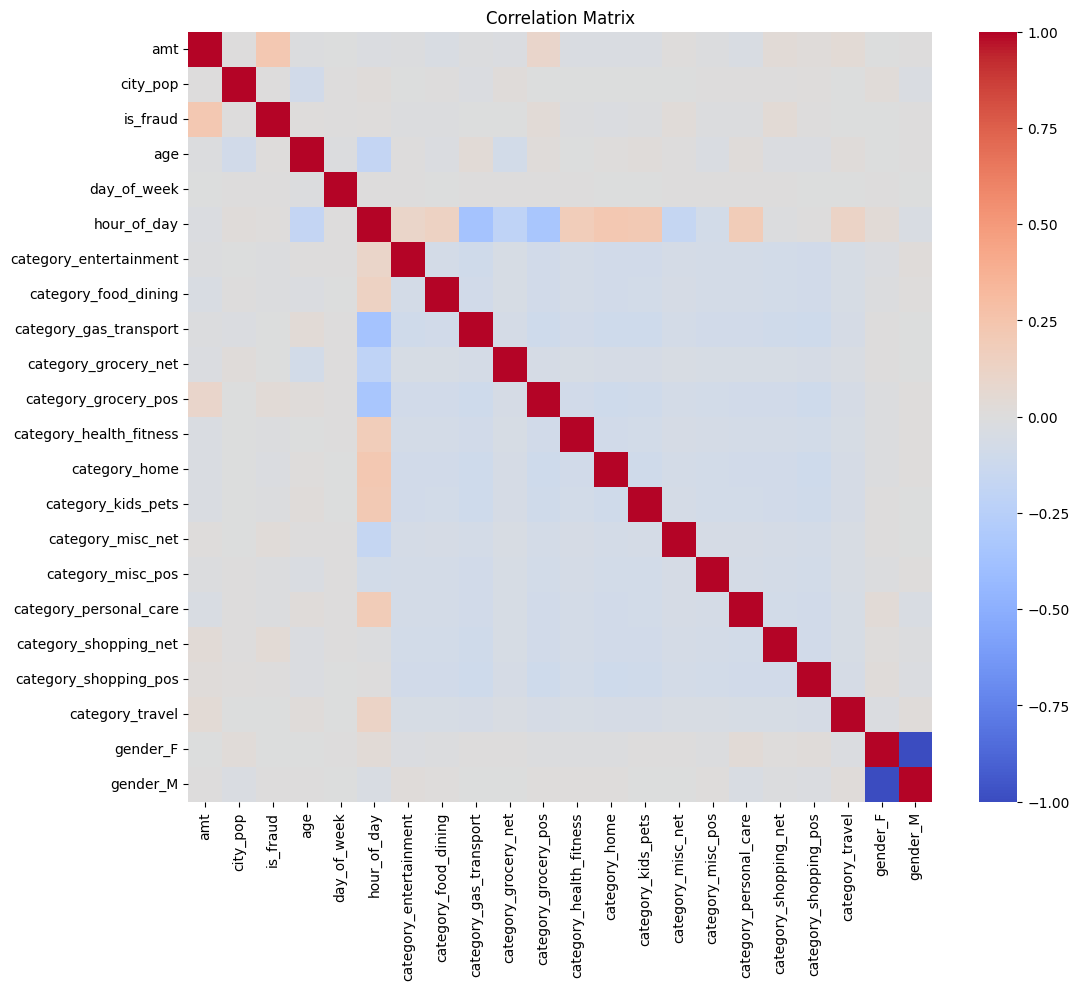

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(ml_df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Drop the non-beneficial ID columns
ml_df = ml_df.drop(['gender_F', 'gender_M'], axis=1, errors='ignore')

In [ ]:
# Display the column names and a preview of the data
print("Columns in the dataset:")
print(ml_df.columns)

Columns in the dataset:
Index(['amt', 'city_pop', 'is_fraud', 'age', 'day_of_week', 'hour_of_day',
       'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split

# Define features and label
X = ml_df.drop(['is_fraud'], axis=1)
y = ml_df['is_fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test data
predictions = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))


Accuracy: 0.9985077216727399
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.94      0.79      0.86      1520

    accuracy                           1.00    259335
   macro avg       0.97      0.90      0.93    259335
weighted avg       1.00      1.00      1.00    259335



In [ ]:
from joblib import dump

# Save the model to disk
dump(rf_model, 'random_forest_model.joblib')


['random_forest_model.joblib']

In [ ]:
from google.colab import files

# Download the file to your computer
files.download('random_forest_model.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>